# Installation

In [1]:
%pip install transformer_lens
%pip install einops
%pip install plotly
%pip install jaxtyping
%pip install protobuf==3.20.*
%pip install pytorch_lightning
%pip install pytorch
%pip install numpy
%pip install tqdm
%pip install matplotlib
%pip install circuitsvis

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-7oiqxkas/pytorch_6096722bb69b4f9fbf43aef839eb8a87/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch

# Setup

## Imports

In [6]:
#import statements
import torch 
import numpy as np
from transformer_lens import HookedTransformer, HookedTransformerConfig
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display, clear_output, Image as IPyImage
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import functools
from transformer_lens import utils
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import plotly.io as pio
import circuitsvis as cv
from PIL import Image


pio.renderers.default = "png"

## Function Definitions

### Nice Normal Functions

In [5]:
def generate_digit_dataset(n_examples, n_digits, reversed_output=False, n_equals=0):
    # Generate a dataset of equations that involve an addition between two numbers with n_digits
    assert n_examples <= 10 ** (n_digits * 2)
    dataset = set()
    while len(dataset) != n_examples:
        # Sample random numbers
        a = np.random.randint(0, 10**n_digits)
        b = np.random.randint(0, 10**n_digits)
        dataset.add(generate_digit_datapoint(a, b, n_digits, reversed_output, n_equals))
    return list(dataset)

def generate_digit_datapoint(a, b, n_digits, reversed_output, n_equals):
    bos = ''
    sep = '=' * n_equals
    a_fwd = f'{a:>0{n_digits}d}'
    b_fwd = f'{b:>0{n_digits}d}'
    c_fwd = f'{a+b:>0{n_digits+1}d}'
    if reversed_output:
        return f"{bos}{a_fwd[::-1]}{b_fwd[::-1]}{sep}{c_fwd[::-1]}"
    else:
        return f"{bos}{a_fwd}{b_fwd}{sep}{c_fwd}"

def tokenize_strings(strings):
    vocab = "0123456789=^"
    vocab2idx = {v: i for i, v in enumerate(vocab)}
    # Tokenize a list of strings
    tokens = np.zeros((len(strings), len(strings[0])), dtype=np.int64)
    for i, string in enumerate(strings):
        idxs = [vocab2idx[char] for char in list(string)]
        tokens[i] = np.array(idxs)
    return tokens

class TokenizedDataset(torch.utils.data.Dataset):

    def __init__(self, tokens):
        # Tokens should be of shape N_examples x N_chars x D_tokens
        self.tokens = torch.tensor(tokens).long()

    def __getitem__(self, index):
        # Should return an example of N_chars x D_tokens
        return self.tokens[index]

    def __len__(self):
        return self.tokens.shape[0]

In [25]:
def construct_model(n_layers, n_heads, d_head, attn_only=False, disable_b=False):
    # Create a HookedTransformer
    print(f'construct_model n_heads={n_heads}, d_head={d_head}')
    cfg = HookedTransformerConfig(
        n_layers=n_layers,
        n_heads=n_heads,
        d_model=128,
        d_head=d_head,
        d_mlp=512 if not attn_only else None,
        act_fn="gelu" if not attn_only else None,
        attn_only=attn_only,
        normalization_type=None,
        attention_dir="causal",
        d_vocab=12,
        d_vocab_out=10,
        n_ctx=3*n_digits+1+n_equals, # Create appropriate context size for strings
        init_weights=True,
        device="cuda"
    )
    model = HookedTransformer(cfg)
    if disable_b:
        for name, param in model.named_parameters():
            if "b_" in name:
                param.requires_grad = False
    return model

def loss_fn(logits, labels):
    # Logits is shape B x P x D, labels is B x P
    log_probs = logits.reshape(-1, logits.shape[-1]).log_softmax(dim=-1)
    labels = labels.reshape(-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()

def acc_fn(logits, labels):
    with torch.no_grad():
        # We can't differentiate this
        preds = logits.argmax(dim=-1)
        correct = preds == labels
        return torch.sum(correct).item() / np.prod(correct.shape)


def train_model(model, train_loader, test_loader, n_epochs, verbose=False,):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, ) #betas=(0.9, 0.98), weight_decay=1.,)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

    train_acc = []
    test_acc = []
    
    epoch_tqdm = tqdm(total=n_epochs, desc='Training model', leave=True)
    loss_plot = widgets.Output()

    # Display widgets
    display(epoch_tqdm)
    display(loss_plot)
    
    checkpoints = []
    next_checkpoint = 0

    for epoch in range(n_epochs):
        epoch_tqdm.update(1) # update progress bar

        acc = []
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            n_batch, n_pos = batch.shape
            cutoff = n_pos - n_digits - 1
            X = torch.cat((batch[:, :cutoff], 10 * torch.ones(n_batch, n_digits + 1, dtype=torch.long)), dim=1).cuda() # Pad with = where the output should be
            labels = batch[:, cutoff:].cuda()
            logits = model(X)[:, cutoff:]
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            acc.append(acc_fn(logits, labels))
        train_acc.append(np.array(acc).mean())

        acc = []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                n_batch, n_pos = batch.shape
                cutoff = n_pos - n_digits - 1
                X = torch.cat((batch[:, :cutoff], 10 * torch.ones(n_batch, n_digits + 1, dtype=torch.long)), dim=1).cuda()
                labels = batch[:, cutoff:].cuda()
                logits = model(X)[:, cutoff:]
                acc.append(acc_fn(logits, labels))
        test_acc.append(np.array(acc).mean())

        scheduler.step()
        if verbose:
            print(f"Epoch: {epoch + 1}, Train Acc: {train_acc[-1]*100:.3f}%, Test Acc: {test_acc[-1]*100:.3f}%")
        with loss_plot:
            plt.clf() # clear current figure
            plt.plot(train_acc, label='Train acc')
            plt.plot(test_acc, label='Test acc')
            plt.title('Accuracy over Time')
            plt.xlabel('Iteration')
            plt.ylabel('Accuracy')
            plt.legend()
            clear_output(wait=True)
            display(plt.gcf()) # display current figure
            plt.close() # close current figure to free memory
        
        if epoch >= next_checkpoint:
            checkpoints.append((epoch, {k:v.clone() for k, v in model.named_parameters()}))
            next_checkpoint = max(next_checkpoint + 1, next_checkpoint * 1.1)

    return train_acc, test_acc, checkpoints

### Evil interactivity functions that use globals

In [26]:
def configure_and_train(
    _n_digits,
    _reversed_output,
    _n_equals,
    _n_heads,
    _d_head,
    _n_train_set,
    _n_test_set,
    _batch_size,
    _n_epochs
):
    global n_digits, reversed_output, n_equals, n_train_set, n_test_set, batch_size, n_epochs, n_heads, d_head
    global strings, tokens, train_set, test_set
    global train_loader, test_loader
    global model
    global train_acc, test_acc, checkpoints
    
    n_digits        = _n_digits
    reversed_output = _reversed_output
    n_equals        = _n_equals
    n_heads         = _n_heads
    d_head          = _d_head
    n_train_set     = _n_train_set
    n_test_set      = _n_test_set
    batch_size      = _batch_size
    n_epochs        = _n_epochs

    strings   = generate_digit_dataset(n_train_set + n_test_set, n_digits, reversed_output, n_equals)
    tokens    = tokenize_strings(strings)
    train_set = TokenizedDataset(tokens[:n_train_set])
    test_set  = TokenizedDataset(tokens[n_train_set:])

    # Create Dataloaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    
    # And then actually train the model
    model = construct_model(1, n_heads=n_heads, d_head=d_head, attn_only=True)
    train_acc, test_acc, checkpoints = train_model(model, train_loader, test_loader, n_epochs, verbose=False)

    print(f"Train acc: {train_acc[-1]}")
    print(f"Test acc: {test_acc[-1]}")

In [8]:
def view_attn_pattern(a=1234, b=1234):
    global model, n_digits, reversed_output, n_equals
    
    input_str = generate_digit_datapoint(a, b, n_digits, reversed_output, n_equals)
    tokens = tokenize_strings([input_str,])

    _,size = tokens.shape
    string_tokens = []
    for i in range(size):
      string_tokens.append(str(tokens[0][i]))
    print(string_tokens)
    tokens = torch.tensor(tokens).long().cuda()
    output = model(tokens).argmax(2)

    print("Here is the output",output[0, -(n_digits+1):])

    logits, cache = model.run_with_cache(tokens)
    html = cv.attention.attention_patterns(
        tokens = string_tokens,
        attention=cache["pattern", 0][0]
    )

    return display(html)

# Training

In [38]:
# Set the defaults
n_digits        = 6
reversed_output = True
n_equals        = 0
n_heads         = 32
d_head          = 2
n_train_set     = 25_000
n_test_set      = 2_000
batch_size      = 256
n_epochs        = 1000

# Configure the training run the first time, so that just running the notebook end
# to end works
configure_and_train(
    n_digits,
    reversed_output,
    n_equals,
    n_heads,
    d_head,
    n_train_set,
    n_test_set,
    batch_size,
    n_epochs
)

construct_model n_heads=32, d_head=2


Training model:   0%|          | 0/1000 [00:00<?, ?it/s]

Output()

Train acc: 0.987700202503682
Test acc: 0.9813456632653061


## See how the embed + pos embed projects into attention space for each head

In [39]:
def show_head_projections(checkpoint_idx, head_idx):
    epoch, checkpoint  = checkpoints[checkpoint_idx]
    model_named_params = dict(checkpoint)
    
    W_E   = model_named_params['embed.W_E']
    W_pos = model_named_params['pos_embed.W_pos']

    W_Q   = model_named_params['blocks.0.attn.W_Q']
    W_K   = model_named_params['blocks.0.attn.W_K']
    W_O   = model_named_params['blocks.0.attn.W_O']
    W_V   = model_named_params['blocks.0.attn.W_V']

    b_Q   = model_named_params['blocks.0.attn.b_Q']
    b_K   = model_named_params['blocks.0.attn.b_K']
    b_O   = model_named_params['blocks.0.attn.b_O']
    b_V   = model_named_params['blocks.0.attn.b_V']

    W_U   = model_named_params['unembed.W_U']
    b_U   = model_named_params['unembed.b_U']

    proj = dict(
        k=np.zeros((model.cfg.n_heads, model.cfg.n_ctx, 10, model.cfg.d_head)),
        q=np.zeros((model.cfg.n_heads, model.cfg.n_ctx, 10, model.cfg.d_head)),
        o=np.zeros((model.cfg.n_heads, model.cfg.n_ctx, 10, model.cfg.d_head)),
        v=np.zeros((model.cfg.n_heads, model.cfg.n_ctx, 10, model.cfg.d_head))
    )
    for head in range(model.cfg.n_heads):
        for position in range(model.cfg.n_ctx):
            proj_k_pos = ((W_E[:10,:] + W_pos[position,np.newaxis]) @ W_K[head,:,:] + b_K[head, np.newaxis,:])
            proj_q_pos = ((W_E[:10,:] + W_pos[position,np.newaxis]) @ W_Q[head,:,:] + b_Q[head, np.newaxis,:])
            proj_v_pos = ((W_E[:10,:] + W_pos[position,np.newaxis]) @ W_V[head,:,:] + b_V[head, np.newaxis,:])
            # Not sure I have the math right here for how to work backwards
            # from unembed and W_O to attn space
            proj_o_pos = ((W_O[head,:,:]@(W_U[:,:10]) + b_O[head, np.newaxis])).T
            proj['k'][head,position,:,:] = proj_k_pos.cpu().detach().numpy()
            proj['q'][head,position,:,:] = proj_q_pos.cpu().detach().numpy()
            proj['v'][head,position,:,:] = proj_v_pos.cpu().detach().numpy()
            proj['o'][head,position,:,:] = proj_o_pos.cpu().detach().numpy()
            
    fig, axes = plt.subplots(2, 4, figsize=(12, 9))
    
    head = head_idx
    for ix, param_name in enumerate("qkvo"):
        param_proj = proj[param_name]

        # Plot the position, for this head, of all projections of q/k/v/o
        # into attention space
        #  - for each digit for position 0
        #  - for each position for digit 0

        # Start with digits
        ax = axes[0][ix]
        ax.set_title(f'Head {head}: attn.{param_name.upper()}\nd_model -> d_head\ndigit 0..9, pos=0')
        sc = ax.scatter([], [], c='b', marker='o')
        axplt = ax.plot(
            param_proj[head,0,[d%10 for d in range(11)],0],
            param_proj[head,0,[d%10 for d in range(11)],1],
            marker="o",
            markersize=4,
            color=[0.5,0.5,0.5],
            linewidth=0.3,
        )
        for digit in range(10):
            ax.annotate(
                str(digit),
                param_proj[head,0,digit,:],
                textcoords="offset points",
                xytext=(0,5),
                ha='center',
            )

        # And then do positions
        ax = axes[1][ix]
        ax.set_title(f'Head {head}: attn.{param_name.upper()}\nd_model -> d_head\ndigit 0, pos=0..{model.cfg.n_ctx}')
        axplt = ax.plot(
            param_proj[head,:,0,0],
            param_proj[head,:,0,1],
            marker="o",
            markersize=4,
            color=[0.5,0.5,0.5],
            linewidth=0.3,
        )
        for position in range(model.cfg.n_ctx):
            if position < n_digits:
                pos_name = f'a:{position}'
                color = [0.5, 0.5, 0.0]
            elif position < 2*n_digits:
                pos_name = f'b:{position-n_digits}'
                color = [1.0, 0.25, 0.0]
            else:
                pos_name = f'b:{position-n_digits}'
                color = [1, 0.75, 0.80]

            ax.annotate(
                str(position),
                param_proj[head,position,0,:],
                textcoords="offset points",
                xytext=(0,5),
                ha='center',
                color=color
            )
    plt.savefig(f'/workspace/attn_projection_anims/head-{head:03d}.epoch-{epoch:06d}.png')
    print(f"saved /workspace/attn_projection_anims/head-{head:03d}.epoch-{epoch:06d}.png")
    plt.close()


In [40]:
head_idx = 19

for checkpoint_idx, _ in enumerate(checkpoints):
    show_head_projections(checkpoint_idx, head_idx)

gif_path = f'/workspace/attn_projection_anims/head-{head_idx:03d}.gif'
for checkpoint_idx, _ in enumerate(checkpoints):
    image_path = f'/workspace/attn_projection_anims/head-{head_idx:03d}.epoch-{epoch:06d}.png'
    image = Image.open(image_path)
    images.append(image)
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)
display(IPyImage(filename=gif_path))

saved /workspace/attn_projection_anims/head-019.epoch-000000.png
saved /workspace/attn_projection_anims/head-019.epoch-000001.png
saved /workspace/attn_projection_anims/head-019.epoch-000002.png
saved /workspace/attn_projection_anims/head-019.epoch-000003.png
saved /workspace/attn_projection_anims/head-019.epoch-000004.png
saved /workspace/attn_projection_anims/head-019.epoch-000005.png
saved /workspace/attn_projection_anims/head-019.epoch-000006.png
saved /workspace/attn_projection_anims/head-019.epoch-000007.png
saved /workspace/attn_projection_anims/head-019.epoch-000008.png
saved /workspace/attn_projection_anims/head-019.epoch-000009.png
saved /workspace/attn_projection_anims/head-019.epoch-000010.png
saved /workspace/attn_projection_anims/head-019.epoch-000011.png
saved /workspace/attn_projection_anims/head-019.epoch-000013.png
saved /workspace/attn_projection_anims/head-019.epoch-000014.png
saved /workspace/attn_projection_anims/head-019.epoch-000015.png
saved /workspace/attn_pro

NameError: name 'epoch' is not defined

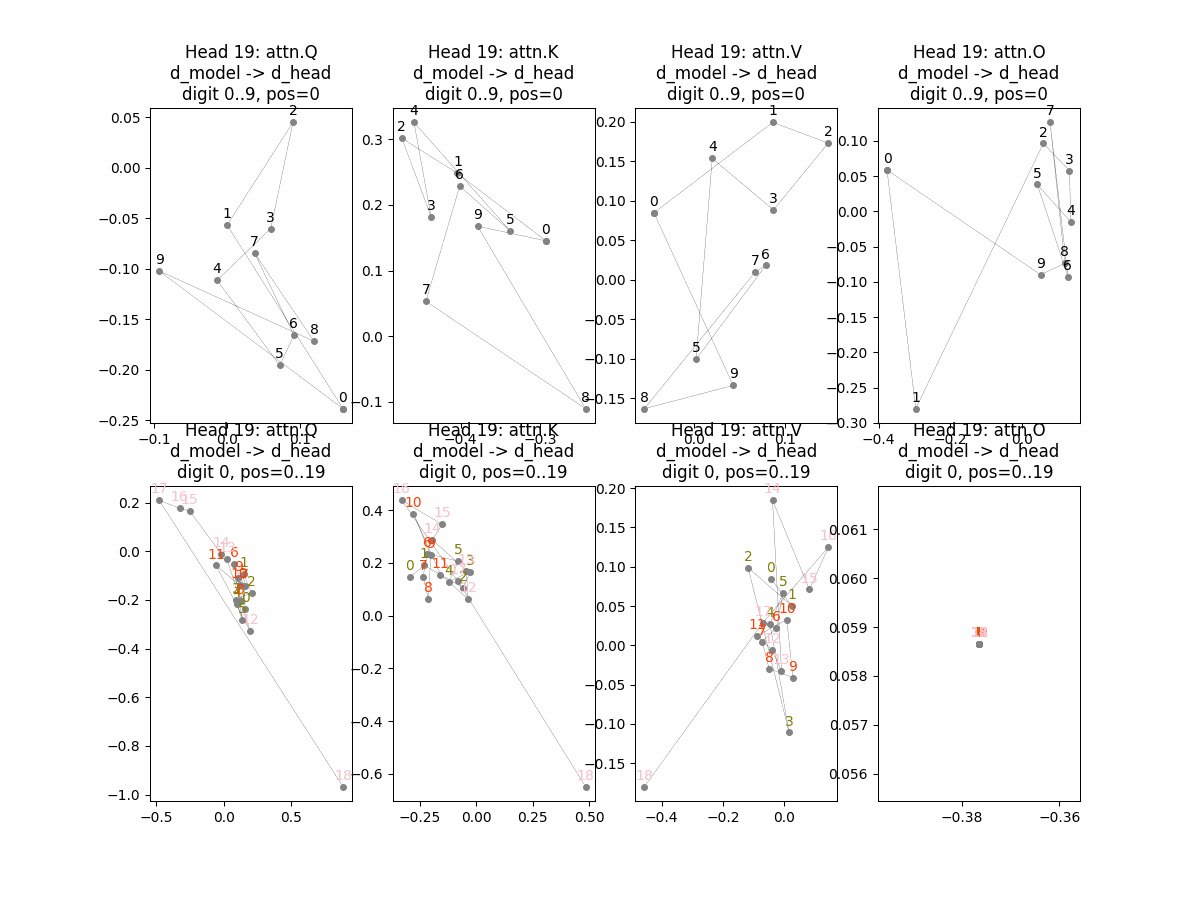

In [47]:
from PIL import Image
images = []
for epoch, _ in checkpoints:
    image_path = f'/workspace/attn_projection_anims/head-{head_idx:03d}.epoch-{epoch:06d}.png'
    image = Image.open(image_path)
    images.append(image)
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)
display(IPyImage(filename=gif_path))

In [49]:
for head_idx in range(32):
    for epoch, _ in enumerate(checkpoints):
        show_head_projections(checkpoint_idx, head_idx)
        gif_path = f'/workspace/attn_projection_anims/head-{head_idx:03d}.gif'
    for epoch, _ in enumerate(checkpoints):
        image_path = f'/workspace/attn_projection_anims/head-{head_idx:03d}.epoch-{epoch:06d}.png'
        image = Image.open(image_path)
        images.append(image)
    images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)

saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_projection_anims/head-000.epoch-000000.png
saved /workspace/attn_pro

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/attn_projection_anims/head-000.epoch-000001.png'